# Game Quizz

## Concept
Le but du projet est de créer un programme qui permet de jouer à un quizz sur des jeux-vidéos.

### TODO

* Update question selection system


### Done
* Point system -> up to 5 points per year guessed, with -1 point per year of difference -> score = percentage of total points at the end of the quizz
* What should they guess? Release year? Platform? -> Release Year
* Store smaller images
* During the quizz, pause using an input() after the player sent his guess
* Get more games?
* Store games' platform
* Change score system for platforms: make him guess several platforms?
* Multiplayer? (have usernames, number of players)
* Save/Load video-game data?
* Add a timer: at then end, give the player 0
* Save/Load player scores?
* Fix timer
* Give a more generous score the older the game is
* Put project on GitHub
* Make the API call get random pages, not the first ones
* Implement dev question

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import requests
import random
import IPython.display as Disp
# Makes it so that Jupyter displays the returned values after executing a cell,
#even when they are not at the very end of the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import time
import pandas as pd
import os
import numpy as np
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)       # tells matplotlib to save plots at 300 DPI

In [3]:
class Constants:
    N_GAME_PAGES = 1
    GAME_DATA_CSV_FILENAME = "games2.csv"
    SCORES_DATA_CSV_FILENAME = "scores.csv"
    SECONDS_PER_RELEASE_GUESS = 15
    SECONDS_PER_PLATFORM_GUESS = 15
    GAME_IS_OLD_THRESHOLD = 1990
    PENLALITY_PERCENTAGE_LOST_PER_YEAR = 15/18
    LAST_PAGE = 700

## Récupérer nos données
Dans cette partie, on demande l'API GiantBomb des données sur des jeux.

In [4]:
def generate_random_pages(n):
    pages = []
    for i in range(n):
        random_page = random.randint(1, Constants.LAST_PAGE)
        while random_page in pages:
            random_page = random.randint(1, Constants.LAST_PAGE)
        pages.append(random_page)
    return pages

In [5]:
# Requests one page of games (= around 100 games)
def request_games(page=1):
    api_key = "1477bd4a4a4481e35aece36a1320ecbde880573a"
    user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.132 Safari/537.36"
    offset = 100 * (page - 1)
    url = "https://www.giantbomb.com/api/games/?api_key=1477bd4a4a4481e35aece36a1320ecbde880573a&format=json&offset=" + str(offset)
    headers = {"api_key": api_key, "format": "json", "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.132 Safari/537.36"}
    result = requests.get(url, headers = headers).json()
    return result

def request_game_pages(n):
    pages = generate_random_pages(n)
    all_pages = []
    for i in pages:
        games = request_games(i)
        all_pages.append(games["results"])
        time.sleep(2)
    return all_pages

In [6]:
result = request_game_pages(Constants.N_GAME_PAGES)

In [7]:
generate_random_pages(10)

[679, 26, 587, 428, 477, 456, 273, 606, 654, 411]

### Récupérer les entreprises qui ont développé les jeux-vidéos
Nous avons récupéré ces données via cette page Wikipedia:https://en.wikipedia.org/wiki/List_of_video_game_developers.

Nous avons extrait la table de cette page en un csv via cet outil: https://wikitable2csv.ggor.de/.

In [8]:
company_data = pd.read_csv("companies.csv")

In [9]:
companies = list(company_data["Developer"])

Nous voulons extraire le/les entreprises qui ont développé chaque jeu via la description de ce jeu.

In [10]:
import re

# first_page = request_game_pages(1)
description_example = result[0][0]["description"]

def get_overview_section(description):
    regex = r"<h2>Overview<\/h2><p>(.+)<h2>"
    match = re.match(regex, description)
    if match:
        return match.groups(1)[0]
    return ""

def get_matches_list(s, matches):
    return [match for match in matches if match in s]
            
def extract_devs(description, all_devs):
    overview = get_overview_section(description)
    devs =  get_matches_list(overview, all_devs)
    return devs

## Convertion du JSON en instances de la classe Game

In [11]:
class Game:
    
    def __init__(self, usable, name, release_year, image, platforms, devs):
        self.usable = usable
        self.name = name
        self.release_year = release_year
        self.image = image
        self.platforms = platforms
        self.devs = devs
    
    @classmethod
    def from_json(cls, json):
        usable = True
        name = json["name"]
        
        release_year = json["original_release_date"]
        if release_year == None:
            expected = json["expected_release_year"]
            if expected == None:
                usable = False
                return
            release_year = int(json["expected_release_year"])
        else:
            release_year = int(release_year[:4])
            
        image = json["image"]["small_url"]
        platforms_jon = json["platforms"]
        if platforms_jon == None:
            platforms = []
        else:
            platforms = [platform["name"] for platform in platforms_jon]
        
        description = json["description"]
        if description:
            devs = extract_devs(description, companies)
        else:
            devs = []  
            
        return Game(usable, name, release_year, image, platforms, devs)
    
    @classmethod
    def from_row(cls, row):
        return Game(True, row[0], row["release_year"], row["image"], row["platforms"], row["devs"])

In [12]:
def extract_games_as_objects(json):
    games = []
    for game_json in json:
        game = Game.from_json(game_json)
        if game and game.usable:
            games.append(game)
    return games

# Builds Game instances from JSON
def extract_all_pages(pages_json):
    all_games = []
    for page in pages_json:
        games = extract_games_as_objects(page)
        for game in games:
            all_games.append(game)
    return all_games

games = extract_all_pages(result)
len(games)

91

In [13]:
result[0][0]

{'aliases': None,
 'api_detail_url': 'https://www.giantbomb.com/api/game/3030-38633/',
 'date_added': '2012-06-09 11:00:40',
 'date_last_updated': '2014-01-24 17:03:58',
 'deck': "Ninja Gaiden Clans brings Team Ninja's franchise to mobile devices with a focus on social networking.",
 'description': '<p>.</p>',
 'expected_release_day': None,
 'expected_release_month': None,
 'expected_release_quarter': None,
 'expected_release_year': None,
 'guid': '3030-38633',
 'id': 38633,
 'image': {'icon_url': 'https://giantbomb1.cbsistatic.com/uploads/square_avatar/0/1992/2232148-ngc.jpg',
  'medium_url': 'https://giantbomb1.cbsistatic.com/uploads/scale_medium/0/1992/2232148-ngc.jpg',
  'screen_url': 'https://giantbomb1.cbsistatic.com/uploads/screen_medium/0/1992/2232148-ngc.jpg',
  'screen_large_url': 'https://giantbomb1.cbsistatic.com/uploads/screen_kubrick/0/1992/2232148-ngc.jpg',
  'small_url': 'https://giantbomb1.cbsistatic.com/uploads/scale_small/0/1992/2232148-ngc.jpg',
  'super_url': 'http

## Convertir nos instances de Game en DataFrame (fichier Excel)

In [14]:
# Returns a dataframe containing the data from a list of Game instances
def get_df_from_objs(games):
    data = {
        "name": [game.name for game in games], 
        "release_year": [game.release_year for game in games],
        "image": [game.image for game in games],
        "platforms": [game.platforms for game in games],
        "devs": [game.devs for game in games]
    }
    return pd.DataFrame(data)

def get_objs_from_df(df):
    games = []
    for row in df.iterrows():
        print(row)
        print(row[1])
        game = Game(row[1], row[1], row[1], row[1])
        games.append(game)
    return games

df = get_df_from_objs(games)
df.head(15)

,name,release_year,image,platforms,devs
0,Ninja Gaiden Clans,2012,https://giantbomb1.cbsistatic.com/uploads/scal...,"[iPhone, iPad, Android]",[]
1,Pro Cycling Manager Season 2012: Le Tour de Fr...,2012,https://giantbomb1.cbsistatic.com/uploads/scal...,[PC],[Cyanide]
2,Starvoid,2012,https://giantbomb1.cbsistatic.com/uploads/scal...,[PC],[]
3,The Lord of the Rings Online: Riders of Rohan,2012,https://giantbomb1.cbsistatic.com/uploads/scal...,[PC],[]
4,Wizardry Online,2013,https://giantbomb1.cbsistatic.com/uploads/scal...,[PC],[]
5,Zumba Fitness Core,2012,https://giantbomb1.cbsistatic.com/uploads/scal...,"[Xbox 360, Wii, Xbox 360 Games Store]",[]
6,J-League Fighting Soccer: The King of Ace Stri...,1992,https://giantbomb1.cbsistatic.com/uploads/scal...,"[Game Boy, Nintendo Entertainment System]",[]
7,miCoach by adidas,2012,https://giantbomb1.cbsistatic.com/uploads/scal...,"[Xbox 360, PlayStation 3]",[]
8,UnchainBlades EXXIV,2012,https://giantbomb1.cbsistatic.com/uploads/scal...,"[PlayStation Portable, PlayStation Network (PS...",[]
9,Drilling Billy,1997,https://giantbomb1.cbsistatic.com/uploads/scal...,[PC],[]


## Stocker & Charger les données en local

In [15]:
import ast

def store_game_data(df):
    df.to_csv(Constants.GAME_DATA_CSV_FILENAME, index=False)

# Returns  a list of Game instances
def load_game_data_locally():
    df =  pd.read_csv(Constants.GAME_DATA_CSV_FILENAME)
    df.platforms = df.platforms.apply(ast.literal_eval) # converts platforms as one string to list of strings
    df.devs = df.devs.apply(ast.literal_eval)           # same for devs
    games = list(df.apply(Game.from_row, axis=1))
    return games
    
# Returns game data as Game instances by either fetching it using the API or getting it locally from a CSV
def get_data(force_fetch=False):
    if os.path.isfile(Constants.GAME_DATA_CSV_FILENAME) and not force_fetch:
        return load_game_data_locally()
    json = request_game_pages(Constants.N_GAME_PAGES)
    games = extract_all_pages(result)
    df = get_df_from_objs(games)
    store_game_data(df)
    return games

games = get_data()

## Implémentation du quizz

In [16]:
def get_unique_platforms(games):
    all_platforms = [platform for game in games for platform in game.platforms]
    all_unique_platforms = set(all_platforms)
    return list(all_unique_platforms)

unique_platforms = get_unique_platforms(games)
len(unique_platforms)

38

In [24]:
class Question():
    
    def __init__(self, launch_function, condition_function):
        self.launch_function = launch_function
        self.condition_function = condition_function

In [31]:
question_objs = [
    Question(release_year_question, lambda game : True),
    Question(platform_question, lambda game : len(game.platforms) > 0),
    Question(dev_question, lambda game : len(game.devs) > 0),
]

In [25]:
dev_question_obj = Question(dev_question, lambda game: len(game.devs) > 0)

In [28]:
dev_question_obj.condition_function(games[8])

True

In [37]:
def guess(game, question_objs):
    image_obj = Disp.Image(requests.get(game.image).content)
    Disp.display(image_obj)
    question_function = pick_question(game, question_objs)
    score = question_function(game)
    return score

# Picks an element at random
# questions is a list containing our question functions
def pick_e_from_list(l):
    random_index = random.randint(0, len(l) - 1)
    random_e = l[random_index]
    return random_e

# picks a question for a given game
def pick_question(game, question_objs):
    question_obj = pick_e_from_list(question_objs)
    while question_obj.condition_function(game) == False:
        question_obj = pick_e_from_list(question_objs)
    return question_obj.launch_function
 
# reduces the score by a factor.
def apply_time_penalty(score, time_taken, max_time):
    penalty_threshold = max_time * 0.33
    if time_taken < penalty_threshold:
        return score
    elif time_taken > max_time:
        return 0
    return score * ((max_time - time_taken) / max_time)
    
def release_year_question(game):
    max_time = Constants.SECONDS_PER_RELEASE_GUESS
    start_time = time.time()
    
    answer = int(input("When was " + '"' + game.name + '" released? '))
    end_time = time.time()
    time_he_took_to_answer = end_time - start_time
    score = compute_score(answer, game)
    score_with_time_penalty = apply_time_penalty(score, time_he_took_to_answer, max_time)
    print("It was released in " + str(game.release_year))
    print("You got a score of " + str(round(score_with_time_penalty)) + "%")
    print("You lost " + str(round(score - score_with_time_penalty)) + "% because of time")
    return score

def get_wrong_answer(all_answers, n, blacklist):
    wrong_answers = []
    for i in range(n):
        random_answer = all_answers[random.randint(0, len(all_answers) - 1)]
        while random_answer in wrong_answers or random_answer in blacklist:
            random_answer = all_answers[random.randint(0, len(all_answers) - 1)]
        wrong_answers.append(random_answer)
    return wrong_answers

# Return a dictionary associating each element in l to a unique identifier (int)
def get_identifier_dict(l):
    d = {e: 0 for e in l}
    for i, e in enumerate(l):
        d[e] = i + 1
    return d

# Prints the MCQ and gets an answer
def mcq(identifier, question_template):
    # prints the question
    for k, v in identifier.items():
        print(str(v) + ": " + k)
        
    answer_v = int(input(question_template))
    answer = [k for k in identifier.keys() if identifier[k] == answer_v][0]
    return answer

def platform_question(game, platforms_to_guess_prop=0.5):
    n_platforms_to_guess = round(platforms_to_guess_prop * len(game.platforms))
    if n_platforms_to_guess == 0:
        n_platforms_to_guess = 1
        
    max_time = Constants.SECONDS_PER_PLATFORM_GUESS * n_platforms_to_guess
    
    
    platform_per_index = {}
    for i, platform in enumerate(unique_platforms):
              platform_per_index[i + 1] = platform
    
    displayed_platform_indexes = []
    for platform in game.platforms:
        platform_index = list(platform_per_index.values()).index(platform) + 1
        displayed_platform_indexes.append(platform_index)
    n_bad_options = random.randint(n_platforms_to_guess + 1, round(n_platforms_to_guess * 2))
    for i in range(n_bad_options):
        random_platform_index = random.randint(0, len(platform_per_index))
        if random_platform_index not in displayed_platform_indexes:
            displayed_platform_indexes.append(random_platform_index)
    
    for i, platform in platform_per_index.items():
        if i in displayed_platform_indexes:
            print(str(i) + ": " + platform)
            
    start_time = time.time()
    guesses = []
    for i in range(n_platforms_to_guess):    
        answer = int(input("Which platform was this game on? (" + str(i+1) + "/" + str(n_platforms_to_guess) + ")"))       
        platform_guessed = platform_per_index[answer]
        guesses.append(platform_guessed)
    time_he_took = time.time() - start_time   
    
    correct_guesses = [guess for guess in guesses if guess in game.platforms]
    n_correct_guesses = len(correct_guesses)
    score = n_correct_guesses / n_platforms_to_guess * 100
    
    score_with_time_penalty = apply_time_penalty(score, time_he_took, max_time)
    print("You found " + str(n_correct_guesses) + " platforms out of " + str(n_platforms_to_guess))
    print("This game was released on " + str(len(game.platforms)) + " platforms: ")
    print("Game's platforms: " + str(game.platforms))
    print("You got a score of " + str(round(score_with_time_penalty)) + "%")
    print("You lost " + str(round(score - score_with_time_penalty)) + "% because of time")
    return score

def mcq_question(game, right_answers, all_answers, question_template, time_per_question):
    n = len(right_answers)
    n_wrong_answers = random.randint(n + 2, n + 3)
    wrong_answers = get_wrong_answer(all_answers, n_wrong_answers, right_answers)
    
    right_wrong = wrong_answers
    for e in right_answers:
        right_wrong.append(e)
    
    identifier = get_identifier_dict(right_wrong)
    
    max_time = time_per_question * n
    start_time = time.time()
    guesses = []
    for i in range(n):
        guess = mcq(identifier, question_template)
        guesses.append(guess)
    time_he_took = time.time() - start_time
    
    correct_guesses = [guess for guess in guesses if guess in right_answers]
    n_correct_guesses = len(correct_guesses)
    score = n_correct_guesses / n * 100
    
    score_with_time_penalty = apply_time_penalty(score, time_he_took, max_time)
    print("You found " + str(n_correct_guesses) + " out of " + str(n))
    print("Correct Answers: " + str(right_answers))
    print("You got a score of " + str(round(score_with_time_penalty)) + "%")
    print("You lost " + str(round(score - score_with_time_penalty)) + "% because of time")
    return score

def dev_question(game):
    return mcq_question(game, game.devs, companies, "Which company developped this game? ", 10)

def platform_question_2(game):
    return mcq_question(game, game.platforms, unique_platforms, "Which plafrom was this game released on? ", 10)
              
def compute_score(answer, game):
    game_is_old = True if game.release_year <= Constants.GAME_IS_OLD_THRESHOLD else False 
    old_amount = Constants.GAME_IS_OLD_THRESHOLD - game.release_year
    penality_per_year = 20 if not game_is_old else 20 - Constants.PENLALITY_PERCENTAGE_LOST_PER_YEAR * old_amount
    print("penality_per_year: " + str(penality_per_year) )
    difference = abs(game.release_year - answer)
    return max(0, 100 - (difference * penality_per_year))

def quizz(games, size, question_objs):
    sum_scores = 0
    for i in range(size):
        random_index = random.randint(0, len(games))
        game = games[random_index]
        score = guess(game, question_objs)
        sum_scores += score
        if i != (size - 1):
            input("Continue? ")
            print("-" * 100)
    success_percentage = sum_scores / size
    return success_percentage

In [18]:
my_function = lambda x: x * 2
my_function(2)

questions = [my_function_1, my_function_2]

4

In [163]:
platform_question_2(games[0])

1: ZX Spectrum
2: Windows Phone
3: Wii
4: Amstrad CPC
5: iPhone
Which plafrom was this game released on? 1
You found 0 out of 1
Correct Answers: ['iPhone']
You got a score of 0%
You lost 0% because of time


0.0

In [33]:
def muliplayer_quizz(games, players, games_per_player, question_objs):
    scores_per_player = {player: [] for player in players}
    
    for i in range(games_per_player):
        for player in players:
            print("\nIt's " + player + "'s turn now'\n")
            input("Continue? ")
            score = quizz(games, 1, question_objs)
            scores_per_player[player].append(score)
    return scores_per_player

In [39]:
def display_scores(scores_per_player):
    print()
    for player in scores_per_player.keys():
        average_score = sum(scores_per_player[player]) / len(scores_per_player[player])
        print(player + " got an average score of " + str(round(average_score)) + "%")


It's Kalou's turn now'

Continue? 


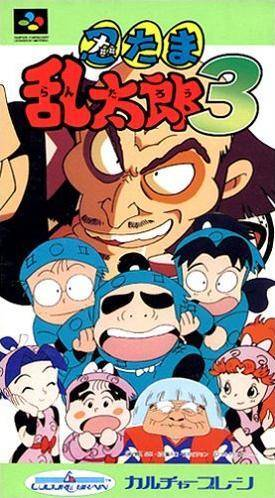

When was "Nintama Rantarou 3" released? 2000
penality_per_year: 20
It was released in 1997
You got a score of 23%
You lost 17% because of time

It's Tilup's turn now'

Continue? 


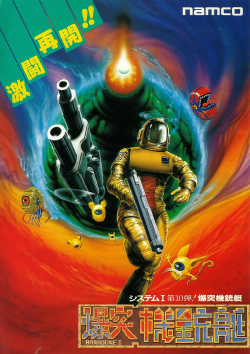

13: Wii Shop
18: Sharp X68000
27: DSiWare
35: Arcade
Which platform was this game on? (1/1)13
You found 1 platforms out of 1
This game was released on 2 platforms: 
Game's platforms: ['Arcade', 'Wii Shop']
You got a score of 60%
You lost 40% because of time


NameError: name 'display_scores' is not defined

In [38]:
players = ["Kalou", "Tilup"]
scores_per_player = muliplayer_quizz(games, players, 1, question_objs)
display_scores(scores_per_player)

## Sauvegarder & Charger les scores des joueurs

In [16]:
def initialize_scores():
    initial_scores = pd.DataFrame({"player": ["J1", "J2"], "scores": [[50, 60], [50, 60]]}) 
    initial_scores.to_csv(Constants.SCORES_DATA_CSV_FILENAME, index=False)

def load_scores():
    df = pd.read_csv(Constants.SCORES_DATA_CSV_FILENAME)
    df.scores = df.scores.apply(ast.literal_eval) # converts list as one string to list of int
    return df

def update_scores(df):
    df.to_csv(Constants.SCORES_DATA_CSV_FILENAME, index=False)

# Updates the csv file by adding the score: might add a new line if the player is new
def insert_score(player, score, df):
    player_list = list(df["player"])
    if player in player_list:
        # mettre à jour
        print("Mise à jour")
        player_index = player_list.index(player)
        player_line = df.iloc[player_index]
        current_scores = player_line["scores"]
        current_scores.append(score)
        player_line["scores"] = current_scores
    else:
        # créer une nouvelle ligne
        print("Nouvelle ligne")
        df = df.append({"player": player, "scores": [score]}, ignore_index=True)
    update_scores(df)

def save_new_scores(scores_per_player):
    df = load_scores()
    for player, scores in scores_per_player.items():
        mean_score = np.mean(scores)
        insert_score(player, mean_score, df)

In [ ]:
save_new_scores(scores_per_player)

## Visualiser les scores

### Comparer les joueurs

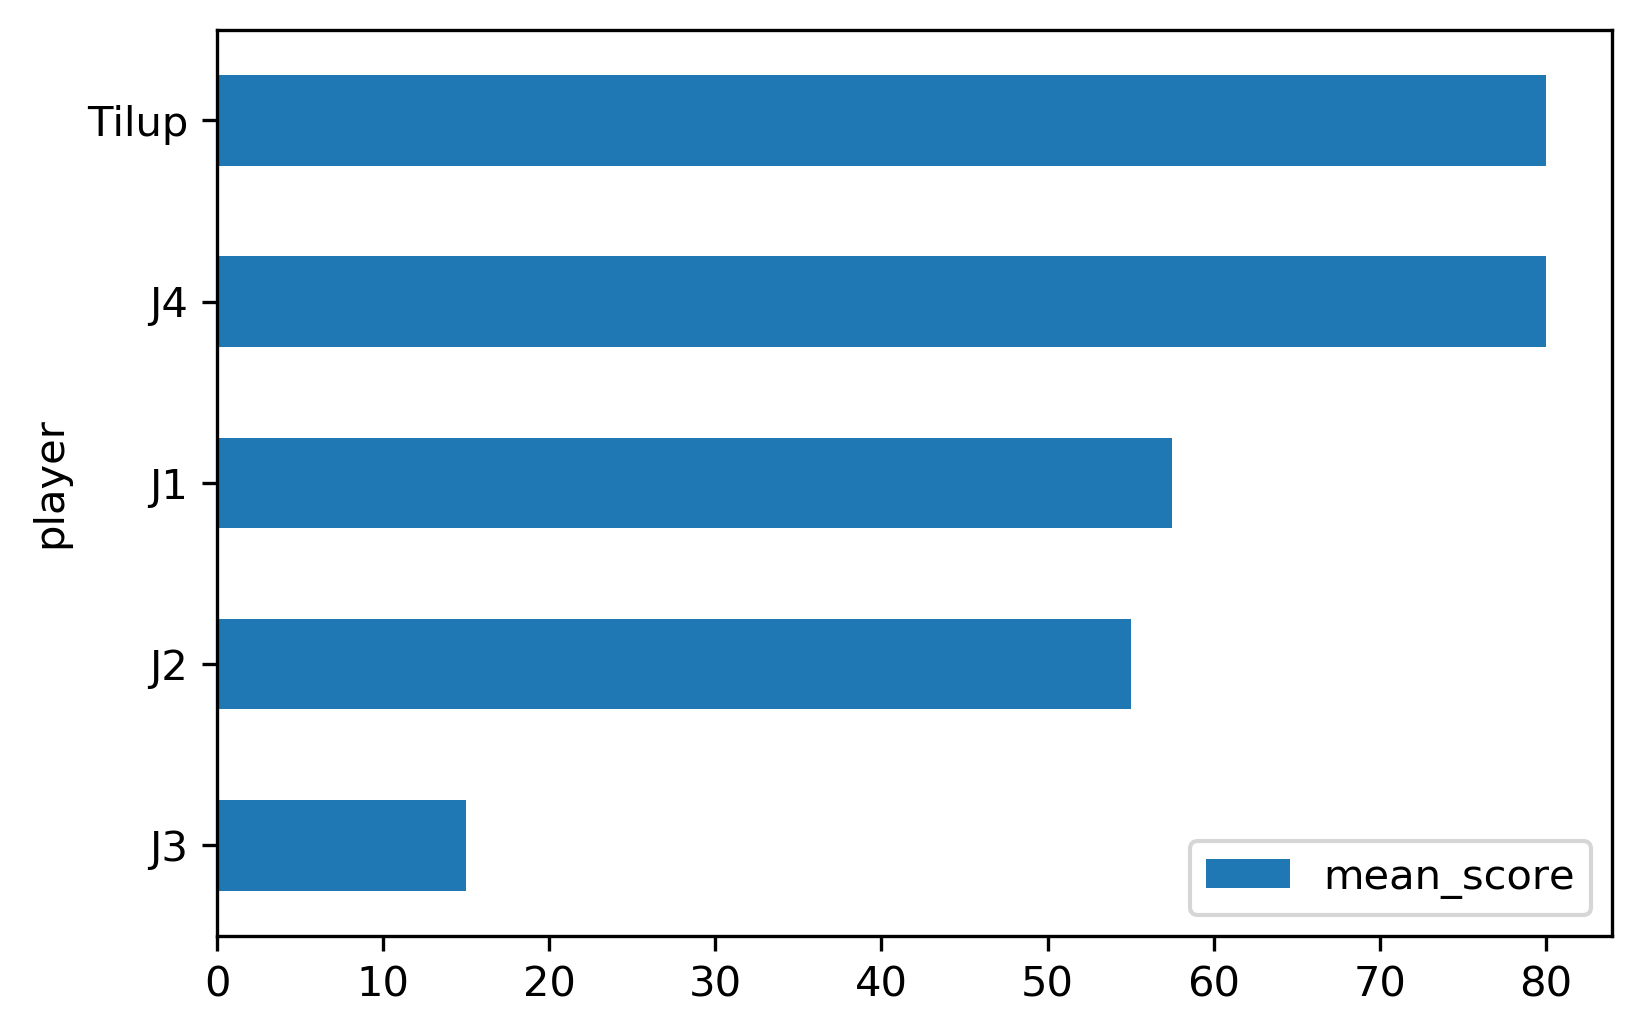

In [19]:
def compare_players():
    scores = load_scores()
    scores.index = scores["player"]
    scores["mean_score"] = scores["scores"].apply(np.mean, axis=0)
    scores["mean_score"]
    scores[["player", "mean_score"]].sort_values(by="mean_score").plot.barh()
    
compare_players()

### Evolution des scores d'un seul et même joueur

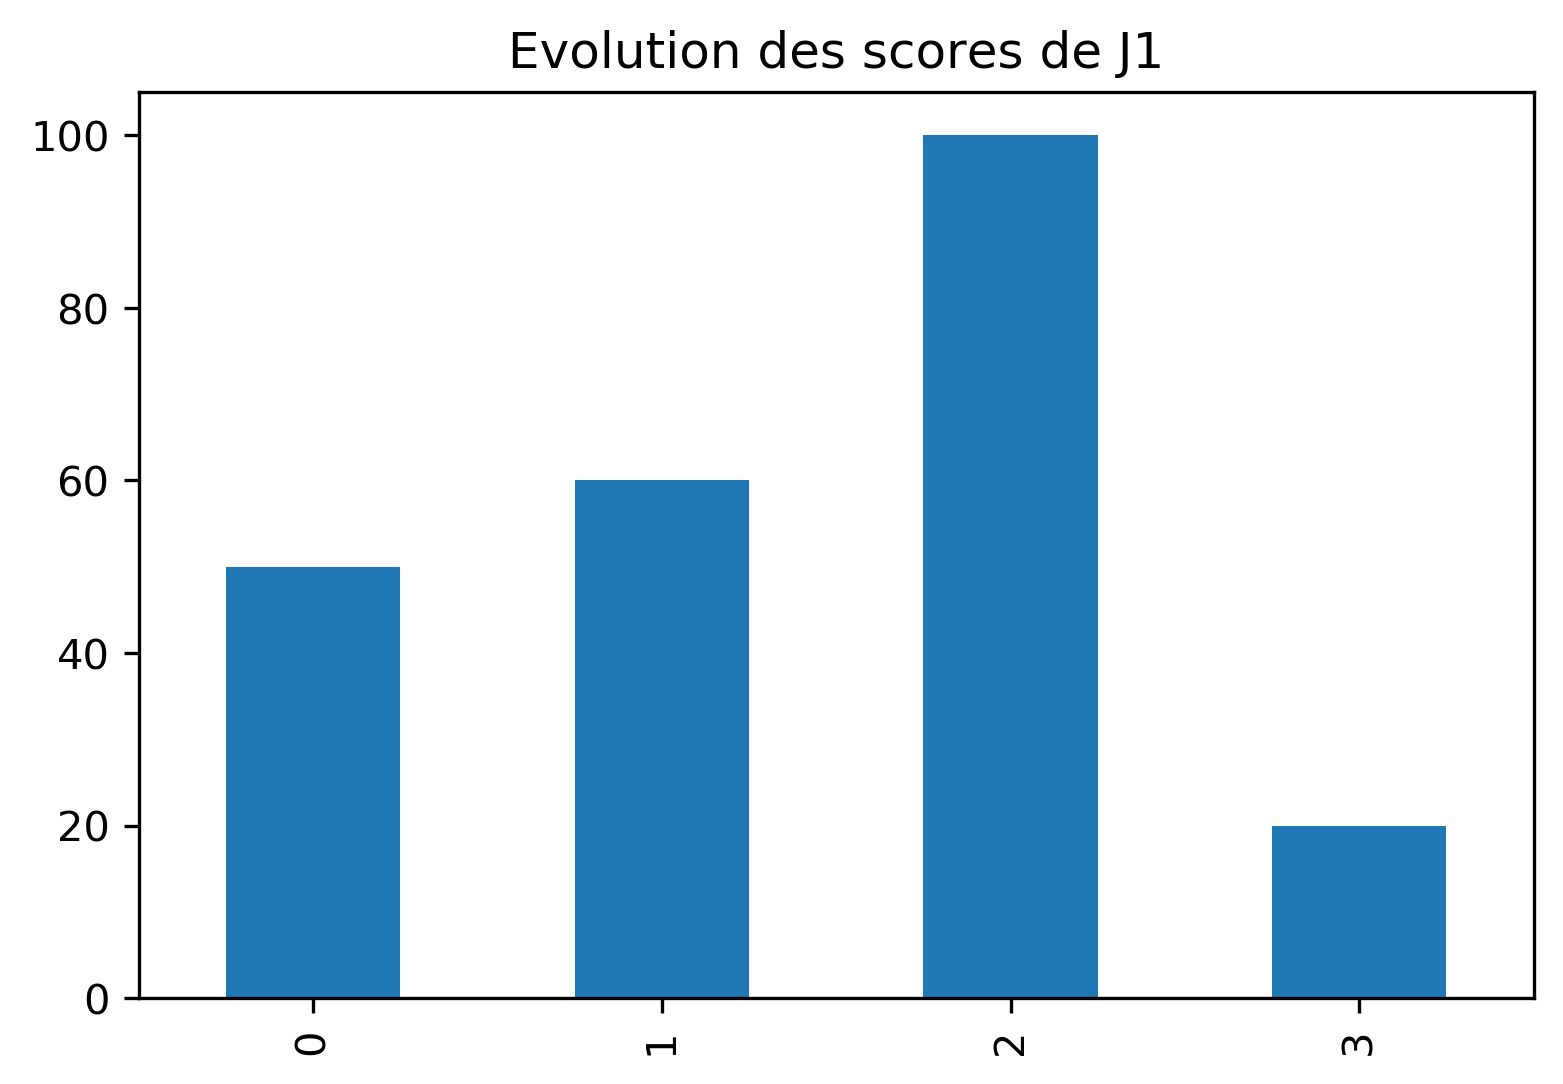

In [20]:
def visualize_player_historic(player):
    scores = load_scores()
    player_index = list(scores["player"]).index(player)
    player_row = scores.iloc[player_index]
    player_scores = player_row["scores"]
    pd.Series(player_scores).plot.bar(title="Evolution des scores de " + player)
    
visualize_player_historic("J1")

## Distribution des années de sortie de nos jeux

In [74]:
years = [game.release_year for game in games]
years = pd.Series(years)
years.value_counts(normalize=True).sort_values(ascending=False) * 100

2003    5.199842
2002    5.191927
2004    4.986150
2000    4.970321
2005    4.804116
2006    4.724970
2007    4.629996
2001    4.527107
1994    4.305501
1999    4.210526
1995    4.123467
1991    4.052236
1993    4.028492
1997    3.909774
1996    3.909774
1998    3.901860
1992    3.846458
1990    3.727740
1989    3.419074
1988    2.801741
1987    2.603878
1986    2.176494
1983    2.089434
1985    1.662050
1984    1.551247
1982    1.511674
2008    0.965572
1981    0.664820
1980    0.379897
1978    0.229521
2009    0.189949
1979    0.166205
1977    0.079145
1976    0.071231
2011    0.071231
2013    0.063316
2015    0.047487
2010    0.039573
2018    0.039573
1972    0.031658
2012    0.023744
2016    0.023744
2014    0.015829
2020    0.007915
1974    0.007915
2019    0.007915
1975    0.007915
dtype: float64

(array([  15.,  192., 1136., 2098., 2060., 2641., 3122., 1333.,   28.,
          10.]),
 array([1972. , 1976.8, 1981.6, 1986.4, 1991.2, 1996. , 2000.8, 2005.6,
        2010.4, 2015.2, 2020. ]),
 <a list of 10 Patch objects>)

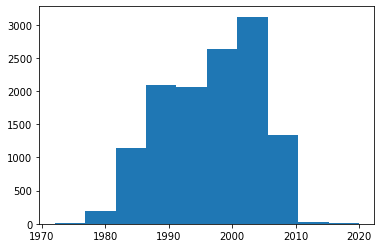

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([game.release_year for game in games])

In [100]:
print(release_year_question(games[1]))

When was "Breakfree" released? 1995
It was released in 1995
You got a score of 100%
You lost 0% because of time
100


In [33]:
d = get_data()

In [48]:
games_test = d.apply(Game.from_row, axis=1)

In [109]:
df["platforms"].head()

0    ['Amiga', 'Game Boy', 'Game Boy Advance', 'Gam...
1                                               ['PC']
2                                               ['PC']
3    ['Amiga', 'Amstrad CPC', 'Apple II', 'Atari ST...
4                                        ['Mac', 'PC']
Name: platforms, dtype: object

In [142]:
df =  pd.read_csv(Constants.GAME_DATA_CSV_FILENAME)
# df["platforms"] = df["platforms"].str.replace('[', '').str.replace(']', '').str.replace("'", '').str.replace(" ", "_").str.replace(",", " ").str.split()
# df["platforms"].str.extractall(pat=r"(\w+ ,)")
# list(df.iloc[1]["platforms"])


df.iloc[0]["platforms"][1]

'Game Boy'

In [201]:
# Utility Functions
def get_game_by_name(name):
    for game in games:
        if game.name == name:
            return game
    return None

f_zero = get_game_by_name("F-Zero: Maximum Velocity")
f_zero.release_year[:4]

{'Kalou': [0.0, 0.0, 0.0, 0.0, 0.0],
 'Tilup': [40.0, 100.0, 100.0, 60.0, 100.0]}

In [41]:
def find_by_release_year(release_year):
    for game in games:
        if game.release_year == release_year:
            return game
        
oldest_game = find_by_release_year(1972)       

In [71]:
first_page[0][0]

{'aliases': 'Desert Strike Advance',
 'api_detail_url': 'https://www.giantbomb.com/api/game/3030-1/',
 'date_added': '2008-04-01 01:32:48',
 'date_last_updated': '2016-02-12 18:45:20',
 'deck': "A top-down isometric helicopter shoot 'em up originally for the Sega Genesis, which was later ported to a variety of platforms. It is best known for its open-ended mission design and was followed by several sequels.",
 'description': '<h2>Overview</h2><p>Desert Strike: Return to the Gulf is an isometric helicopter shoot \'em up from Electronic Arts. The player is a fighter pilot who must take down mission-critical targets across a number of maps. The player is free to pursue these missions in any order, and must also keep an eye on the fuel, damage, and ammo gauges.</p><p>Desert Strike is the first of the prolific <a href="/strike-series/3025-143/" data-ref-id="3025-143">Strike</a> series, and was followed with <a href="/jungle-strike/3030-2180/" data-ref-id="3030-2180">Jungle Strike</a> and <a

In [51]:
companies

{'0verflow',
 '1-Up Studio',
 '11 bit studios',
 '1C Company',
 '2K Czech',
 '2K Games',
 '2K Sports',
 '343 Industries',
 '38 Studios',
 '3D Realms',
 '42 Entertainment',
 '4A Games',
 '5th Cell',
 '989 Studios',
 'ACE Team',
 'AQ Interactive',
 'Access Games',
 'Access Software',
 'Acclaim Entertainment',
 'Acclaim Studios Austin',
 'Accolade',
 'Aces Studio',
 'Acquire',
 'Action Forms',
 'Active Gaming Media',
 'Activision',
 'Adventure Soft',
 'Akella',
 'Alfa System',
 'AlphaDream',
 'Amazon Game Studios',
 'Amazon Game Studios, Orange County (formerly Double Helix Games)',
 'Ambrella',
 'Amusement Vision',
 'Ancient',
 'Anino',
 'Ankama Games',
 'Appy Entertainment',
 'Arc System Works',
 'Arcane Kids',
 'ArenaNet',
 'Arika',
 'Arkane Studios',
 'Arkedo Studio',
 'Art Co., Ltd',
 'Artdink',
 'ArtePiazza',
 'Artificial Studios',
 'Artoon',
 'Arzest',
 'Ascaron',
 'Asobo Studio',
 'Atari Interactive (formerly Hasbro Interactive)',
 'Atlus',
 'Atomic Planet Entertainment',
 'Attic 